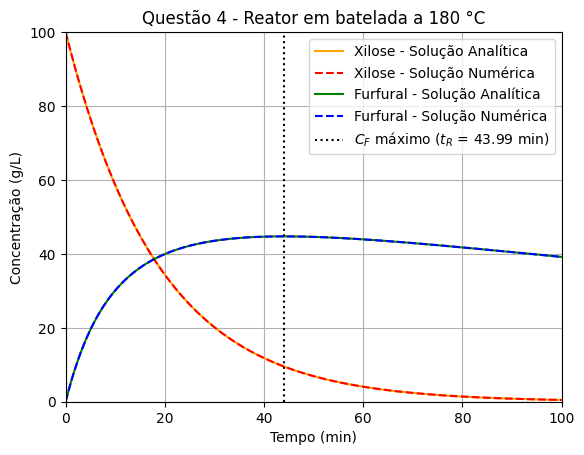

O tempo de reação em que a concentração de furforal é máxima é tR = 43.99 min
A concentração máxima de furfural C_F_max = 44.74 g/L


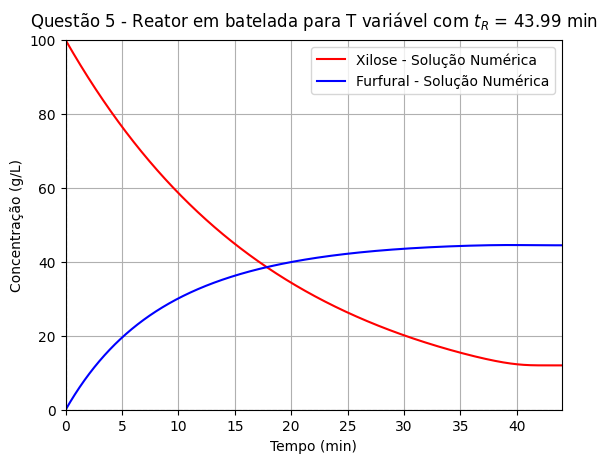

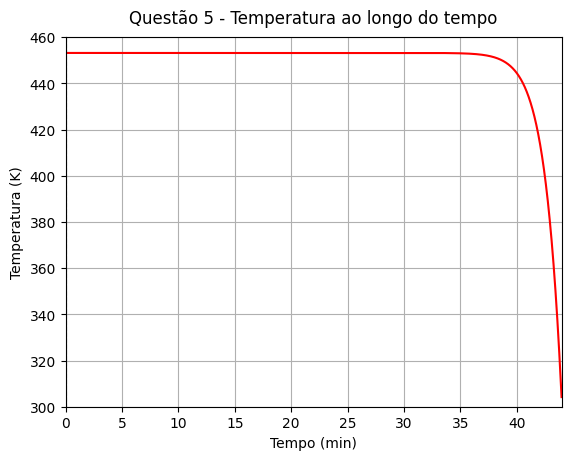

In [ ]:
# ============================================================================ #
#                 PROJETO COMPUTACIONAL: Reator em Batelada
# ============================================================================ #

# Integrantes - Grupo 4:
#

import math
import numpy as np
import matplotlib.pyplot as plt

# Condições do reator
C_H = 0.1 # N (cte)
C_X_0 = 100 # g/L
C_F_0 = 0 # g/L

# Massa específica da água em função da temperatura
def ρ_H2O(T, t):
  ρ_H2O = 9.99864928e2 + 5.72357369e-2 * (T - 273.15) - 7.9600702e-3 * (T - 273.15)**2 + 5.32777547e-5 * (T - 273.15)**3 - 2.6032268e-7 * (T - 273.15)**4 + 5.11178237e-10 * (T - 273.15)**5
  return ρ_H2O

# Cálculo dos parâmetros dependentes da temperatura
def δ(T, t):
  Tj = T(t)
  δ = ρ_H2O(Tj, t)/995.6579965642592
  return δ

def k1(T, t):
  Tj = T(t)
  γx = 1
  k1 = 2.9*δ(T, t)*γx*C_H*np.exp(-16890*((1/Tj) - (1/473.15)))
  return k1

def a(T, t):
  Tj = T(t)
  a = 0.0393*np.exp(5782*((1/Tj) - (1/473.15)))
  return a

def b(T, t):
  Tj = T(t)
  b = np.exp(1936*((1/Tj) - (1/503.15)))
  return b

# ----------------- 1) Solução analítica: Série de Potências ----------------- #

# Solução analítica de concentração de xilose
def C_X(t, T):
  C_X = C_X_0*np.exp(-k1(T, t)*t)
  return C_X

# Função G(a,x) de série de potência
def G(a, x, ε=1e-12, max_it=1000):
  Σ = 0
  n = 0
  while n < max_it:
    denominador = (n + 1 - a)
    if denominador == 0:
      n += 1
      continue  # evita divisão por zero
    termo = ((-1)**n * x**n)/(denominador * math.factorial(n))
    Σ += termo
    if abs(termo) < ε:
      break
    n += 1
  return Σ

# Solução analítica de concentração de furfural
def C_F(t, T):
  Cx = C_X(t, T)/C_X_0
  a_ = a(T, t)
  b_ = b(T, t)
  k1_ = k1(T, t)

  exp1 = np.exp(np.clip(b_ * Cx, None, 700))
  exp2 = np.exp(np.clip(-a_ * k1_ * t, -700, 700))

  G1 = G(a_, b_)
  G2 = np.array([G(a_, b_ * Cxi) for Cxi in Cx])

  return C_X_0 * exp1 * (G1 * exp2 - Cx * G2)

# --------------- 2) Solução numérica: Runge-Kutta de 4ª Ordem --------------- #

# Equação diferencial de consumo de xilose
def dCX_dt(t, C_X, C_F, T):
  dCX_dt = -k1(T, t)*C_X
  return dCX_dt

# Equação diferencial de formação de furfural
def dCF_dt(t, C_X, C_F, T):
  dCF_dt = k1(T, t)*(C_X - a(T, t)*C_F - (b(T, t)/C_X_0)*C_X*C_F)
  return dCF_dt

# Método de Runge-Kutta de 4ª Ordem
def RungeKutta(f, g, t0, y0, z0, h, n):
  t = [t0]
  y = [y0]
  z = [z0]

  for i in range(n):
    ti = t[-1]
    yi = y[-1]
    zi = z[-1]

    k1y = h * f(ti, yi, zi, T)
    k1z = h * g(ti, yi, zi, T)

    k2y = h * f(ti + h/2, yi + k1y/2, zi + k1z/2, T)
    k2z = h * g(ti + h/2, yi + k1y/2, zi + k1z/2, T)

    k3y = h * f(ti + h/2, yi + k2y/2, zi + k2z/2, T)
    k3z = h * g(ti + h/2, yi + k2y/2, zi + k2z/2, T)

    k4y = h * f(ti + h, yi + k3y, zi + k3z, T)
    k4z = h * g(ti + h, yi + k3y, zi + k3z, T)

    y_next = yi + (k1y + 2*k2y + 2*k3y + k4y)/6
    z_next = zi + (k1z + 2*k2z + 2*k3z + k4z)/6
    t_next = ti + h

    t.append(t_next)
    y.append(y_next)
    z.append(z_next)

  return np.array(t), np.array(y), np.array(z)

#------------------------------------------------------------------------------#
#                       QUESTÃO 4 - temperatura constante                      #
#------------------------------------------------------------------------------#

def T(t):
  T = 453.15 # K
  return T

# Condições iniciais
t0 = 0 # min
tf = 100 # min
C_F_0 = 0 # g/L
C_X_0 = 100 # g/L
h = 0.01
n = int((tf - t0)/h)

# Obtenção da solução numérica
t, C_X_numerico, C_F_numerico = RungeKutta(dCX_dt, dCF_dt, t0, C_X_0, C_F_0, h, n)

# Obtenção da solução analítica
C_X_analitico = C_X(t, T)
C_F_analitico = C_F(t, T)

# Determinando o tempo de reação em que a concentração de furfural é máxima
C_F_np = np.array(C_F_numerico)
indice_max = np.argmax(C_F_np)
tR = t[indice_max]
C_F_max = C_F_np[indice_max]

# Gráfico das soluções analítica e numérica
plt.plot(t, C_X_analitico, color="orange", label="Xilose - Solução Analítica")
plt.plot(t, C_X_numerico,color="red", linestyle='--', label="Xilose - Solução Numérica")
plt.plot(t, C_F_analitico, color="green", label="Furfural - Solução Analítica")
plt.plot(t, C_F_numerico, color="blue", linestyle='--', label="Furfural - Solução Numérica")
plt.axvline(x=tR, color='black', linestyle=':', label='$C_F$ máximo ($t_R$ = 43.99 min)')
plt.title("Questão 4 - Reator em batelada a 180 °C")
plt.xlabel("Tempo (min)")
plt.ylabel("Concentração (g/L)")
plt.legend()
plt.axhline(0, color="gray",lw=0.8, ls='--')
plt.axvline(0, color="gray",lw=0.8, ls='--')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

#------------------------------------------------------------------------------#
#                       QUESTÃO 5 - temperatura variável                       #
#------------------------------------------------------------------------------#

# Determinando o tempo de reação em que a concentração de furfural é máxima
C_F_np = np.array(C_F_numerico)
indice_max = np.argmax(C_F_np)
tR = t[indice_max]
C_F_max = C_F_np[indice_max]

print(f"O tempo de reação em que a concentração de furforal é máxima é tR = {tR:.2f} min")
print(f"A concentração máxima de furfural C_F_max = {C_F_max:.2f} g/L")

# Variação da temperatura com o tempo
def T(t):
  T = 453.15 - 150*((t/tR)**30) # K
  return T

# Condições iniciais
t0 = 0 # min
tf = tR # min
C_F_0 = 0 # g/L
C_X_0 = 100 # g/L
h = 0.01
n = int((tf - t0)/h)

# Gráfico das concentrações de xilose e furfural (solução numérica)
t, C_X_numerico, C_F_numerico = RungeKutta(dCX_dt, dCF_dt, t0, C_X_0, C_F_0, h, n)

# Gráfico das concentrações de xilose e furfural (solução numérica)
plt.plot(t, C_X_numerico,color="red", label="Xilose - Solução Numérica")
plt.plot(t, C_F_numerico, color="blue", label="Furfural - Solução Numérica")
plt.xlabel("Tempo (min)")
plt.ylabel("Concentração (g/L)")
plt.title(f'Questão 5 - Reator em batelada para T variável com $t_R$ = {tR:.2f} min', pad=10)
plt.legend()
plt.axhline(0, color="gray",lw=0.8, ls='--')
plt.axvline(0, color="gray",lw=0.8, ls='--')
plt.xlim(0, tR)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

# Gráfico da temperatura
plt.plot(t, T(t),color="red")
plt.xlabel("Tempo (min)")
plt.ylabel("Temperatura (K)")
plt.title(f'Questão 5 - Temperatura ao longo do tempo', pad=10)
plt.axhline(0, color="gray",lw=0.8, ls='--')
plt.axvline(0, color="gray",lw=0.8, ls='--')
plt.xlim(0, tR)
plt.ylim(300, 460)
plt.grid(True)
plt.show()


In [ ]:
print (ρ_H2O(453.15, 0))

886.2912189087615
